In [1]:
import json, time, pathlib
import pandas as pd
import matplotlib.pyplot as plt
import concurrent.futures

from pprint import pprint

import sklearn.datasets
import sklearn.metrics
from sklearn.inspection import plot_partial_dependence, permutation_importance
from sklearn.model_selection import train_test_split

import autosklearn.classification

import concurrent.futures
import time

import sys, os

sys.path.insert(0, os.path.abspath(os.path.join('..', 'src')))

from AutoSklearn.with_ensemble import with_ensemble_experiment
from AutoSklearn.without_ensemble import without_ensemble_experiment


/home/joao/miniconda3/envs/as-env/lib/python3.9/site-packages/sklearn/utils/fixes.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version  # type: ignore


In [2]:
df = pd.read_csv('../data/IMDB Dataset.csv')
X = df.drop(columns=['sentiment'])
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
time_limit = 60 * 45  # 60 * número de minutos
dataset_name = 'IMDB'
tmp_path = pathlib.Path('../results/tmp/' + dataset_name)

Iniciando experimento COM ensemble...
Iniciando experimento SEM ensemble...


/home/joao/miniconda3/envs/as-env/lib/python3.9/site-packages/autosklearn/data/feature_validator.py:318: UserWarning: Input Column review has generic type object. Autosklearn will treat this column as string. Please ensure that this setting is suitable for your task.
  warnings.warn(
/home/joao/miniconda3/envs/as-env/lib/python3.9/site-packages/autosklearn/data/feature_validator.py:318: UserWarning: Input Column review has generic type object. Autosklearn will treat this column as string. Please ensure that this setting is suitable for your task.
  warnings.warn(


[WARNING] [2025-07-11 14:38:55,180:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2025-07-11 14:38:56,697:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2025-07-11 14:38:56,697:Client-EnsembleBuilder] No runs were available to build an ensemble from
SEM ensemble concluído!


/home/joao/miniconda3/envs/as-env/lib/python3.9/site-packages/autosklearn/automl.py:1860: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pd.merge(


COM ensemble concluído!


/home/joao/miniconda3/envs/as-env/lib/python3.9/site-packages/autosklearn/automl.py:1860: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pd.merge(


Todos os experimentos concluídos em 2743.87 segundos


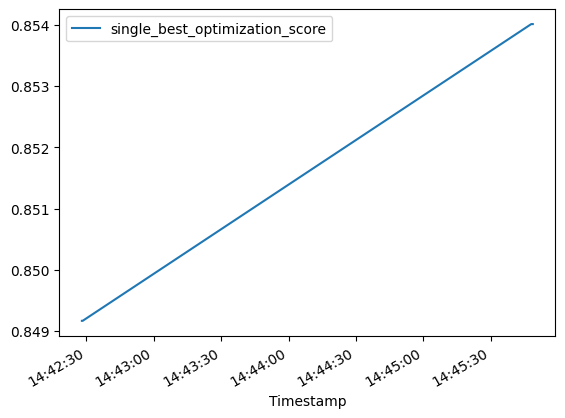

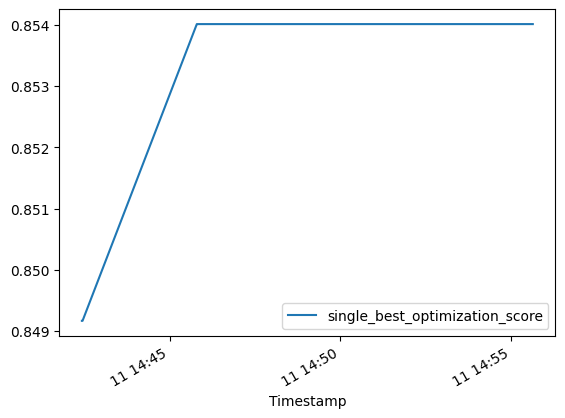

In [4]:
start_time = time.time()

results = {}

def process_result(experiment_name, automl_model):
    """Processa o resultado quando a thread termina"""
    print(f"{experiment_name} concluído!")
    
    predictions = automl_model.predict(X_test)
    accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
    
    results[experiment_name] = {
        'model': automl_model,
        'accuracy': accuracy,
        'predictions': predictions
    }

    df = automl_model.performance_over_time_
    df.plot(x='Timestamp', y='single_best_optimization_score', kind='line')
    
    with open('../results/results.txt', 'a') as f:  
        if experiment_name == 'COM ensemble':
            f.write(f"{dataset_name} - With ensemble:\n")
        else:
            f.write(f"{dataset_name} - Without ensemble:\n")
        f.write(f"Accuracy score: {accuracy}\n")
        elapsed_time = time.time() - start_time
        minutes = int(elapsed_time // 60)
        seconds = int(elapsed_time % 60)
        f.write(f"Finished in: {minutes}m and {seconds}s\n\n")


with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
    print("Iniciando experimento COM ensemble...")
    future_with = executor.submit(
        with_ensemble_experiment, 
        X_train, y_train, time_limit, dataset_name, tmp_path / 'with_ensemble'
    )
    
    print("Iniciando experimento SEM ensemble...")
    future_without = executor.submit(
        without_ensemble_experiment, 
        X_train, y_train, time_limit, dataset_name, tmp_path / 'without_ensemble'
    )

    for future in concurrent.futures.as_completed([future_with, future_without]):
        if future == future_with:
            automl_with_ensemble = future.result()
            process_result("COM ensemble", automl_with_ensemble)
        else:
            automl_without_ensemble = future.result()
            process_result("SEM ensemble", automl_without_ensemble)

total_time = time.time() - start_time
print(f"Todos os experimentos concluídos em {total_time:.2f} segundos")

In [7]:
for result in results:
    print(f"Resultado para {result} teve acurácia de {results[result]['accuracy']:.2f}")
    print("Construção do modelo:")
    pprint(results[result]['model'].show_models(), indent=4)
    print()


Resultado para SEM ensemble teve acurácia de 0.85
Construção do modelo:
{   4: {   'balancing': Balancing(random_state=1),
           'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice object at 0x757cc8a25f10>,
           'cost': 0.1459848484848485,
           'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x757d58ee6a60>,
           'ensemble_weight': 1.0,
           'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x757cc8a25e50>,
           'model_id': 4,
           'rank': 1,
           'sklearn_classifier': MLPClassifier(activation='tanh', alpha=3.542372581884717e-07, beta_1=0.999,
              beta_2=0.9, hidden_layer_sizes=(54, 54),
              learning_rate_init=0.00016753718126302934, max_iter=32,
              n_iter_no_change=32, random_state=1, validation_fraction=0.0,
              verbose=0, warm_start=True)}}

Result